https://github.com/jmxpearson/julia-for-pythonistas

https://www.juliabox.com/

In [1]:
# Example 1.2 from Shumway
using Gadfly
using DataFrames
using RData

# This RDA file is just a list with name 'gtemp', returned as a dict with one key
raw_data = RData.load("data/gtemp.rda", convert=true)
df = DataFrame(Time=1880:2009, TemperatureDeviation=raw_data["gtemp"])

130×2 DataFrames.DataFrame
│ Row │ Time │ TemperatureDeviation │
├─────┼──────┼──────────────────────┤
│ 1   │ 1880 │ -0.28                │
│ 2   │ 1881 │ -0.21                │
│ 3   │ 1882 │ -0.26                │
│ 4   │ 1883 │ -0.27                │
│ 5   │ 1884 │ -0.32                │
│ 6   │ 1885 │ -0.32                │
│ 7   │ 1886 │ -0.29                │
│ 8   │ 1887 │ -0.36                │
│ 9   │ 1888 │ -0.27                │
│ 10  │ 1889 │ -0.17                │
│ 11  │ 1890 │ -0.39                │
⋮
│ 119 │ 1998 │ 0.56                 │
│ 120 │ 1999 │ 0.32                 │
│ 121 │ 2000 │ 0.33                 │
│ 122 │ 2001 │ 0.48                 │
│ 123 │ 2002 │ 0.56                 │
│ 124 │ 2003 │ 0.55                 │
│ 125 │ 2004 │ 0.48                 │
│ 126 │ 2005 │ 0.62                 │
│ 127 │ 2006 │ 0.54                 │
│ 128 │ 2007 │ 0.57                 │
│ 129 │ 2008 │ 0.43                 │
│ 130 │ 2009 │ 0.57                 │

In [2]:
describe(df)

Time
Min      1880.0
1st Qu.  1912.25
Median   1944.5
Mean     1944.5
3rd Qu.  1976.75
Max      2009.0
NAs      0
NA%      0.0%

TemperatureDeviation
Min      -0.39
1st Qu.  -0.2175
Median   -0.05
Mean     -0.021615384615384613
3rd Qu.  0.0975
Max      0.62
NAs      0
NA%      0.0%



In [3]:
df[:Time]

130-element DataArrays.DataArray{Int64,1}:
 1880
 1881
 1882
 1883
 1884
 1885
 1886
 1887
 1888
 1889
 1890
 1891
 1892
    ⋮
 1998
 1999
 2000
 2001
 2002
 2003
 2004
 2005
 2006
 2007
 2008
 2009

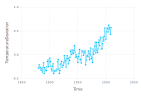

In [4]:
plot(df, x="Time", y="TemperatureDeviation", Geom.point, Geom.line)

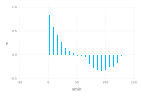

In [5]:
using StatsBase

# NOTE: The columns in DataFrame are DataArray, which must be converted back to
# normal Julia Array before passing to libraries that aren't DataFrame aware. Limits
# usefulness of DataFrames...
df_time = convert(Array, df[:Time])
df_temp = convert(Array, df[:TemperatureDeviation])
lags = 0:length(df_time)-1
acf = autocor(df_temp, lags)
plot(y=acf, xmin=lags-0.1, xmax=lags+0.1, Geom.bar)

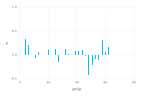

In [19]:
lags = 1:div(length(df_temp),2)-1
temp_pacf = pacf(df_temp, lags)
plot(y=temp_pacf, xmin=lags-0.1, xmax=lags+0.1, Geom.bar)

In [7]:
using MultivariateStats

# Setup up simple linear model for temperature data - assume temp = beta_1 + beta_2 t
X = ones(length(df_time), 2)
X[:,2] = df_time
X

130×2 Array{Float64,2}:
 1.0  1880.0
 1.0  1881.0
 1.0  1882.0
 1.0  1883.0
 1.0  1884.0
 1.0  1885.0
 1.0  1886.0
 1.0  1887.0
 1.0  1888.0
 1.0  1889.0
 1.0  1890.0
 1.0  1891.0
 1.0  1892.0
 ⋮          
 1.0  1998.0
 1.0  1999.0
 1.0  2000.0
 1.0  2001.0
 1.0  2002.0
 1.0  2003.0
 1.0  2004.0
 1.0  2005.0
 1.0  2006.0
 1.0  2007.0
 1.0  2008.0
 1.0  2009.0

In [8]:
beta = llsq(X, df_temp, bias=false)

2-element Array{Float64,1}:
 -11.1995    
   0.00574846

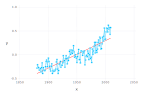

In [27]:
temp_lsq = beta[1]+beta[2]*df_time
plot(layer(x=df_time, y=df_temp, Geom.point, Geom.line),
     layer(x=df_time, y=temp_lsq, Geom.line,
           Theme(default_color=colorant"red")))

In [29]:
SSE = sum((df_temp-temp_lsq).^2)

2.0047673664804937

In [10]:
function scatterMatrix(df::AbstractDataFrame, cols::Vector{String})
    ncols = length(cols)
    plots = Array{Gadfly.Plot}(ncols, ncols)
    xlabel = nothing
    ylabel = nothing
    for i = 1:ncols
        for j = 1:ncols
            if i == ncols
                xlabel = cols[i]
            else
                xlable = nothing
            end
            if j == 1
                ylabel = cols[j]
            else
                ylabel = nothing
            end
            plots[i,j] = plot(df, x=cols[i], y=cols[j],
                              Guide.xlabel(xlabel), Guide.ylabel(ylabel))
        end
    end
    gridstack(plots)
end

scatterMatrix (generic function with 1 method)

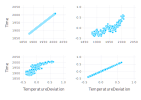

In [11]:
scatterMatrix(df, ["Time", "TemperatureDeviation"])

In [33]:
# Load datasets for Shumway Example 2.2
cmort = RData.load("data/cmort.rda")["cmort"]
tempr = RData.load("data/tempr.rda")["tempr"]
part  = RData.load("data/part.rda")["part"]
temp_deviations = tempr - mean(tempr)
temp_squared = temp_deviations.^2
ts = 1:length(cmort)
df_ctp = DataFrame(time=ts, cmort=cmort, tempr=tempr, temp_deviations=temp_deviations,
                   temp_squared=temp_squared, part=part)

508×6 DataFrames.DataFrame
│ Row │ time │ cmort  │ tempr │ temp_deviations │ temp_squared │ part  │
├─────┼──────┼────────┼───────┼─────────────────┼──────────────┼───────┤
│ 1   │ 1    │ 97.85  │ 72.38 │ -1.88041        │ 3.53595      │ 72.72 │
│ 2   │ 2    │ 104.64 │ 67.19 │ -7.07041        │ 49.9907      │ 49.6  │
│ 3   │ 3    │ 94.36  │ 62.94 │ -11.3204        │ 128.152      │ 55.68 │
│ 4   │ 4    │ 98.05  │ 72.49 │ -1.77041        │ 3.13436      │ 55.16 │
│ 5   │ 5    │ 95.85  │ 74.25 │ -0.0104134      │ 0.000108439  │ 66.02 │
│ 6   │ 6    │ 95.98  │ 67.88 │ -6.38041        │ 40.7097      │ 44.01 │
│ 7   │ 7    │ 88.63  │ 74.2  │ -0.0604134      │ 0.00364978   │ 47.83 │
│ 8   │ 8    │ 90.85  │ 74.88 │ 0.619587        │ 0.383888     │ 43.6  │
│ 9   │ 9    │ 92.06  │ 64.17 │ -10.0904        │ 101.816      │ 24.99 │
│ 10  │ 10   │ 88.75  │ 67.09 │ -7.17041        │ 51.4148      │ 40.41 │
│ 11  │ 11   │ 94.6   │ 78.29 │ 4.02959         │ 16.2376      │ 51.93 │
⋮
│ 497 │ 497  │ 77.36  │ 86.6  │ 12.3396         │ 152.265      │ 62.81 │
│ 498 │ 498  │ 73.63  │ 79.98 │ 5.71959         │ 32.7137      │ 38.61 │
│ 499 │ 499  │ 81.17  │ 90.93 │ 16.6696         │ 277.875      │ 63.6  │
│ 500 │ 500  │ 83.91  │ 93.43 │ 19.1696         │ 367.473      │ 57.53 │
│ 501 │ 501  │ 82.36  │ 90.16 │ 15.8996         │ 252.797      │ 54.97 │
│ 502 │ 502  │ 79.74  │ 80.38 │ 6.11959         │ 37.4493      │ 47.22 │
│ 503 │ 503  │ 73.46  │ 82.37 │ 8.10959         │ 65.7654      │ 69.14 │
│ 504 │ 504  │ 79.03  │ 75.35 │ 1.08959         │ 1.1872       │ 42.17 │
│ 505 │ 505  │ 76.56  │ 72.29 │ -1.97041        │ 3.88253      │ 45.59 │
│ 506 │ 506  │ 78.52  │ 75.68 │ 1.41959         │ 2.01523      │ 70.72 │
│ 507 │ 507  │ 89.43  │ 73.33 │ -0.930413       │ 0.865669     │ 57.58 │
│ 508 │ 508  │ 85.49  │ 70.52 │ -3.74041        │ 13.9907      │ 62.61 │

In [43]:
Z5 = ones(length(cmort), 5)
Z5[:,2] = ts
Z5[:,3] = temp_deviations
Z5[:,4] = temp_squared
Z5[:,5] = part
beta5 = llsq(Z5, cmort, bias=false)
cmort_lsq5 = Z5 * beta5
SSE5 = sum((cmort-cmort_lsq5).^2)

20508.44022061056

In [38]:
Z2 = ones(length(cmort), 2)
Z2[:,2] = ts
beta2 = llsq(Z2, cmort, bias=false)
cmort_lsq2 = Z2 * beta2
SSE2 = sum((cmort-cmort_lsq2).^2)

40019.83714264338

In [44]:
q = 5
r = 2
n = length(cmort)
F = ((SSE2 - SSE5)/(q-r))/(SSE5/(n-q))

159.51534337749405

In [52]:
using Distributions

fd = FDist(q-r, n-q)
Fcrit = quantile(fd, 1-0.001) # find value of s.t. P(F>Fcrit) = 0.001

5.505160543118326